# Report ( 모비딕 )

## curaition 아이디어 소개

>저희 팀은 고객뿐만 아니라 증권회사에게도 이익이 될 수 있는 curation 방안을 생각했습니다.  
증권사는 고객들의 거래량이 늘어날 때 수수료를 통해서 금전적 이익을 얻습니다.  
일반적인 고객들에게 큰 수익을 내는 것보다 리스크를 잘 분배해서 손실을 얼마나 적게 보느냐가 더 중요합니다.  
양측의 이익을 위해서 저희는 '개인용 포트폴리오 curation'을 생각했습니다.
개인은 일반 펀드에서 많은 수수료를 때야지 할 수 있는 포트폴리오 운영을 저희가 추천하는 curation으로 보다 쉽게 할 수 있습니다.  
포트폴리오 curation에는 그룹화된 고객의 성향에 맞게 원자재, 주식, 채권 같은 대략적인 금융상품의 비율이 추천될 것입니다.
추천된 비율 안에서 고객이 직접 선택해서 세부적인 상품들을 채워넣을 수 있게 프레임을 제공합니다.
이를 통해 고객들은 포트폴리오를 통한 분할투자의 효과를 얻을 수 있게됩니다.  
포트폴리오의 각 요소들은 시간이 지남에 따라 그 비율이 변하고, 본래 의도했던 리스크에서 벗어날 수 있습니다.  
그때 필수적으로 포트폴리오에서는 리밸런싱이라는 작업을 해야합니다.  
금융사는 자사 포트폴리오 curaition 서비스를 이용한 고객들에게 그 비율의 표준편차가 일정정도 이상 벗어나면 리밸런싱을 자동적으로 진행해주거나 고객에게 알림을 보내서 리밸런싱을 유도할 수 있습니다.  
리밸런싱으로 하면서 발생하는 거래들의 수수료를 통해서 금융사는 그만큼의 금전적이득을 얻을 수 있습니다.  
저희 '개인용 포트폴리오 curation'은 고객과 증권사 양측이 모두 이익을 얻을 수 있는 win-win 전략입니다.  

## 표적 Data

> 포트폴리오는 단기 투자보다는 장기 투자에 최적화된 전략입니다.  
거래량이 많고 뚜렷한 철학이 있는 단기 투자자들에게 저희가 제공하는 curaition은 효용이 떨어질 것 입니다.  
장기적 투자를 하는 고객들이 포트폴리오 curaition을 했을 때 양측에게 모두 이익이 될 것이라고 판단했습니다.  
거래량과 접속량이 적은 고객들의 Data를 표적 Data로 설정하는 것을 일차적인 목표로 설정했습니다.

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pandasql import sqldf
from sklearn.cluster import KMeans

In [117]:
class Data:
    def __init__(self, mts, tot, byn_sll):
        self.mts = mts
        self.tot = tot
        self.byn_sll = byn_sll

    def __str__(self):
        return 'mts : {}, tot : {}, byn_sll : {}'.format(self.mts, self.tot, self.byn_sll)

def complexToPolar(i):
    return np.arctan(i.imag/i.real), abs(i)
def polarToComplex(theta, r):
    x = r/((np.tan(theta)**2+1)**0.5)
    y = (r**2-x**2)**0.5
    return x+y*1j


In [118]:


cus_ifo = pd.read_csv("./cus_ifo.csv", header=0, usecols=['act_no', 'mts_mm_access_type', 'tot_ivs_te_sgm_cd', 'bas_stk_trd_tp_cd'])
cus_itg = pd.read_csv('./cus_itg_sct_bnc.csv', header=0, usecols=['act_no', 'itg_byn_cns_qty', 'itg_sll_cns_qty'])

cus_ifo['mts_mm_access_type'] = cus_ifo['mts_mm_access_type'].astype('string')
cus_ifo['act_no'] = cus_ifo['act_no'].astype('string')
cus_itg['act_no'] = cus_itg['act_no'].astype('string')

data_mts = {}
data_tot = {}
for row_i, row in cus_ifo.iterrows():
    if row_i > 0 and str(row['bas_stk_trd_tp_cd']) != '1' and str(row['bas_stk_trd_tp_cd']) != '2':
        data_mts[row['act_no']] = row['mts_mm_access_type'].count('1')/6
        tmp = row['tot_ivs_te_sgm_cd']
        if tmp == 99:
            tmp = 1
        data_tot[row['act_no']] = tmp/6

data_byn_sll = {}
for row_i, row in cus_itg.iterrows():
    if row_i > 0:
        byn = row['itg_byn_cns_qty']
        sll = row['itg_sll_cns_qty']
        if row['act_no'] in data_byn_sll:
            tmp = data_byn_sll[row['act_no']]
            data_byn_sll[row['act_no']] = tmp+byn+sll
        else:
            data_byn_sll[row['act_no']] = byn+sll
        

data_set = {}
for key in data_byn_sll:
    if key in data_mts and data_byn_sll[key] <= 10000:
        data_set[key] = Data(data_mts[key], data_tot[key], data_byn_sll[key]/10000)


In [119]:
mts_list = []
tot_list = []
byn_sll_list = []
for key in data_set.keys():
    mts_list.append(data_set[key].mts)
    tot_list.append(data_set[key].tot)
    byn_sll_list.append(data_set[key].byn_sll)

df = pd.DataFrame({'act_no':data_set.keys(), 'mts_mm_access_type':mts_list, 'tot_ivs_te_sgm_cd':tot_list, 'byn_sll':byn_sll_list})

In [120]:
df1=df['mts_mm_access_type'].value_counts()
df1

1.000000    5409
0.833333     977
0.500000     813
0.666667     809
0.333333     765
0.166667     723
Name: mts_mm_access_type, dtype: int64

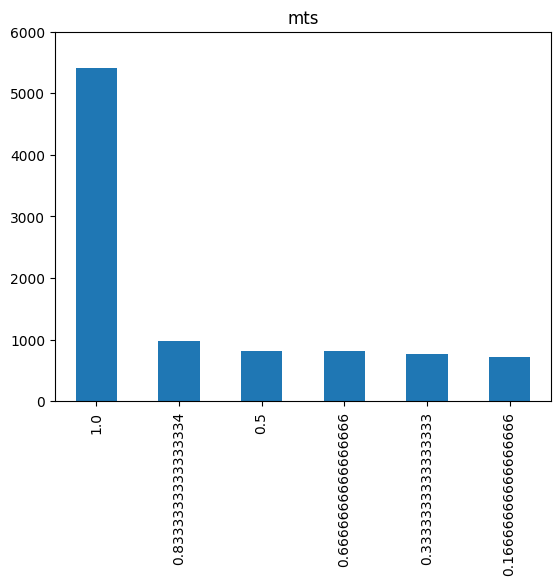

In [121]:
p1 = df1.plot(kind='bar', title='mts', yticks=range(0, 7000, 1000))

In [122]:
df1=df['tot_ivs_te_sgm_cd'].value_counts()
df1

0.500000    3826
0.166667    2927
0.333333    1390
0.666667     528
0.833333     419
1.000000     406
Name: tot_ivs_te_sgm_cd, dtype: int64

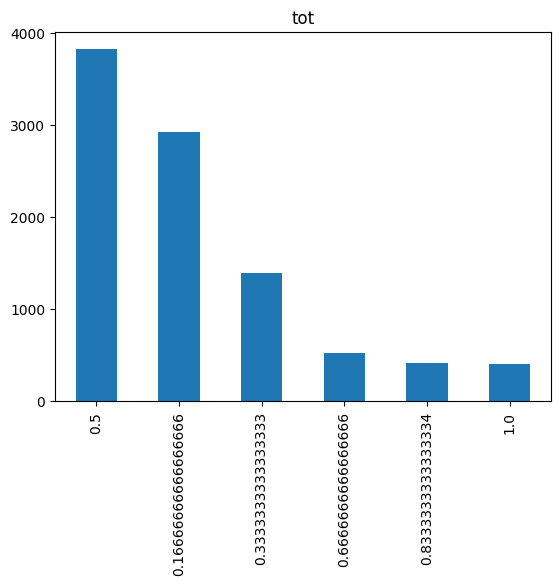

In [123]:
p1 = df1.plot(kind='bar', title='tot', yticks=range(0, 5000, 1000))

In [124]:
df1=df['byn_sll'].value_counts()
df1

0.0000    4345
0.0001     431
0.0002     287
0.0003     172
0.0004     112
          ... 
0.2927       1
0.8400       1
0.0654       1
0.9426       1
0.0663       1
Name: byn_sll, Length: 1545, dtype: int64

In [125]:
filt=df['byn_sll']>0
df.drop(index=df[-filt].index,inplace=True)
df

,act_no,mts_mm_access_type,tot_ivs_te_sgm_cd,byn_sll
5,73a63f06d98225d2153b45c6582e66a9e5fdcba3db1a4e...,1.000000,0.333333,0.1866
6,961e49a3c24a5afde7bbf0748050433da975af2f908bbc...,1.000000,0.333333,0.0006
9,a865b94a13738e48ee67e2215cb3a3f28701365cab8edc...,1.000000,0.666667,0.1895
12,2c9c62a0c7a1502f2a53d6ea2c3b7e1f8afd6087c3d73a...,1.000000,0.500000,0.2370
13,152576271df840a9e7af894df67ea4752051fe4ae80132...,1.000000,0.500000,0.1940
...,...,...,...,...
9485,73d69bbb83adfe1de0d430d4a1caae71b75874f7de3cf0...,1.000000,0.500000,0.0021
9489,1857f41615e73f88afb27fc937b44f72ab0d14c3723305...,0.833333,0.500000,0.0663
9490,ad707555c6eedc1183a0556fa2a41f1611ab2d23d99cf9...,0.666667,0.166667,0.0300
9494,14b6c2ef1b9f411b39bb88cc58bc11519545a2843a2046...,1.000000,0.333333,0.0007


<AxesSubplot: >

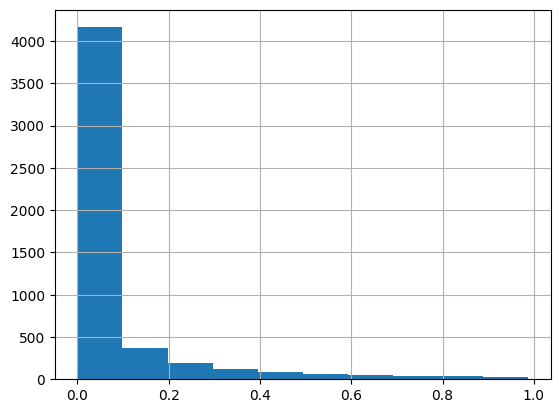

In [126]:
df['byn_sll'].hist()

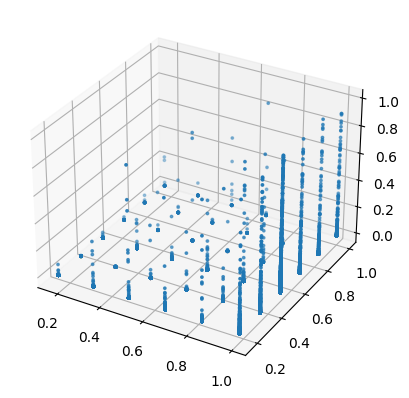

In [127]:
d1 = []
d2 = []
d3 = []
for data in data_set.values():
    d1.append(data.mts)
    d2.append(data.tot)
    d3.append(data.byn_sll)
bd = np.array([d1, d2, d3])
bd = bd.transpose()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(d1, d2, d3, s=3)
plt.show()


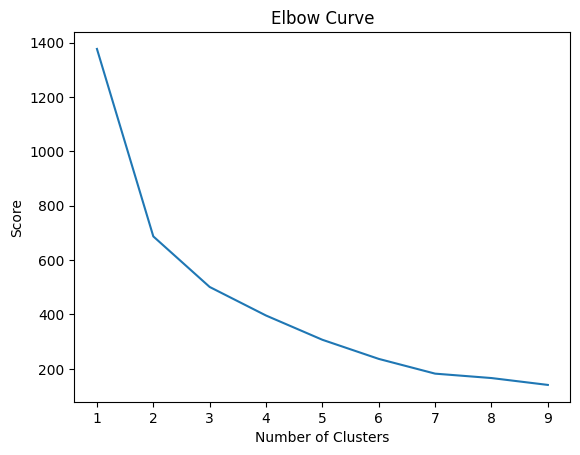

In [128]:
n_clusters = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in n_clusters]

score = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]

plt.plot(n_clusters, score)
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Elbow Curve")
plt.show()

In [129]:
X = np.array(bd)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

df = pd.DataFrame({'mts':bd[:,0], 'tot':bd[:,1], 'byn_sll':bd[:,2], 'group':kmeans.labels_})
df.to_csv('cluster.csv', mode='w')

print(kmeans.cluster_centers_)

[[0.39790545 0.2898863  0.00548794]
 [0.95907217 0.47146476 0.05593063]]


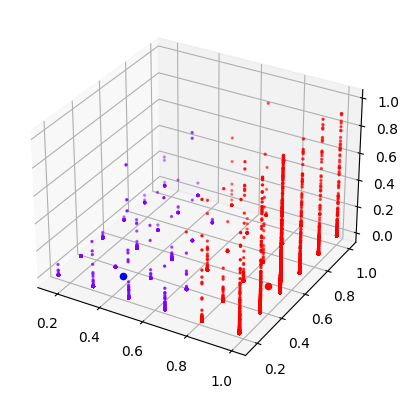

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(d1, d2, d3, c=kmeans.labels_, cmap="rainbow", s=2)

ax.scatter(kmeans.cluster_centers_[0][0], kmeans.cluster_centers_[0][1], kmeans.cluster_centers_[0][2], c='blue', s=20)
ax.scatter(kmeans.cluster_centers_[1][0], kmeans.cluster_centers_[1][1], kmeans.cluster_centers_[1][2], c='red', s=20)
plt.show()



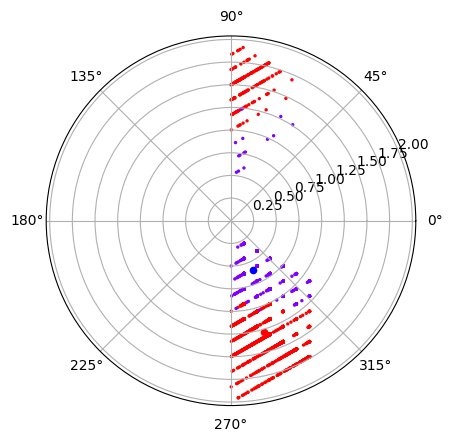

In [131]:
base1 = 1j
base2 = -(3**0.5)*0.5+0.5j
base3 = (3**0.5)*0.5+0.5j
dd = np.array([x[0]*base1+x[1]*base2+x[2]*base3 for x in bd])
dd1 = np.array([np.arctan(x.imag/(x.real+0.0001)) for x in dd])
dd2 = np.array([abs(x) for x in dd])

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.scatter(dd1, dd2, c=kmeans.labels_, cmap="rainbow", s=2)

c1 = kmeans.cluster_centers_[0][0]*base1+kmeans.cluster_centers_[0][1]*base2+kmeans.cluster_centers_[0][2]*base3
c2 = kmeans.cluster_centers_[1][0]*base1+kmeans.cluster_centers_[1][1]*base2+kmeans.cluster_centers_[1][2]*base3

ax.scatter(np.arctan(c1.imag/c1.real), abs(c1), c='blue', s=20)
ax.scatter(np.arctan(c2.imag/c2.real), abs(c2), c='red', s=20)
plt.show()

